In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import bokeh
import numpy as np
from bokeh.models import Circle, ColumnDataSource, Line, LinearAxis, Range1d
from bokeh.plotting import figure, output_notebook, show
from bokeh.core.properties import value
output_notebook()  # output bokeh plots to jupyter notebook
np.random.seed(42)

Loading BokehJS ...

In [3]:
df = pd.read_csv('data/christinaaguilera.csv')
df = df.drop(df[df.release_date == 'None'].index, axis=0)
df = df.reset_index().drop('index', axis=1)
df

,api_path,primary_artist,title,url,song_endpoint,album,release_date,lyrics
0,/songs/3591041,Christina Aguilera,Accelerate,https://genius.com/Christina-aguilera-accelera...,http://api.genius.com/songs/3591041,Liberation,2018-05-03,"Hide it 'til we feel it, then we feel it, 'ti..."
1,/songs/204744,Christina Aguilera,Ain't No Other Man,https://genius.com/Christina-aguilera-aint-no-...,http://api.genius.com/songs/204744,Back to Basics,2006-06-06,"Heeeeey! Yeah (Do your thang, honey!) I cou..."
2,/songs/204971,Christina Aguilera,All I Need,https://genius.com/Christina-aguilera-all-i-ne...,http://api.genius.com/songs/204971,Bionic,2010-06-04,"Kissing your lips, kissing you top to toe Wis..."
3,/songs/783764,Christina Aguilera,Alright Now,https://genius.com/Christina-aguilera-alright-...,http://api.genius.com/songs/783764,None,2018-01-01,"There she stood in the street, smiling from he..."
4,/songs/3233187,Christina Aguilera,America,https://genius.com/Christina-aguilera-america-...,http://api.genius.com/songs/3233187,Served Like a Girl (Music from and Inspired by...,2017-11-03,People come and go through these hotel rooms ...
5,/songs/204662,Christina Aguilera,Angels We Have Heard on High,https://genius.com/Christina-aguilera-angels-w...,http://api.genius.com/songs/204662,My Kind of Christmas,2000-10-24,"Glo-glo-glo-glo-ria Yeah, ooh, oh, ooh oh, ye..."
6,/songs/1872506,Christina Aguilera,Anywhere But Here,https://genius.com/Christina-aguilera-anywhere...,http://api.genius.com/songs/1872506,Finding Neverland: The Album (Songs from the B...,2015-05-04,There's no need for distance No need for touc...
7,/songs/205025,Christina Aguilera,Army of Me,https://genius.com/Christina-aguilera-army-of-...,http://api.genius.com/songs/205025,Lotus,2012-11-09,"I've been standing where you left me, left me..."
8,/songs/205065,Christina Aguilera,Around the World,https://genius.com/Christina-aguilera-around-t...,http://api.genius.com/songs/205065,Lotus,2012-11-09,"Oh, oh, oh, oh Oh, oh, oh, oh Oh, oh, oh, oh ..."
9,/songs/205110,Christina Aguilera,At Last,https://genius.com/Christina-aguilera-at-last-...,http://api.genius.com/songs/205110,None,1999-12-14,At last My love has come along My lonely days...


In [4]:
df.shape

(180, 8)

In [5]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
dtype: int64

In [6]:
lexicon = pd.read_csv('sentiment_lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delim_whitespace=True, header=None)
lexicon.head()

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [7]:
rs_lexicon = lexicon.pivot(index=0, columns=1, values=2)
rs_lexicon.drop(rs_lexicon.index[0], axis=0, inplace=True)
rs_lexicon.head()

1,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [8]:
for col in rs_lexicon.columns:
    print(f'{col}: {rs_lexicon[col].sum()}')

anger: 1247
anticipation: 839
disgust: 1058
fear: 1476
joy: 689
negative: 3324
positive: 2312
sadness: 1191
surprise: 534
trust: 1231


In [9]:
vocabulary = list(rs_lexicon.index)
emotions = {}
for word in vocabulary:
    rs_lex_filtered = rs_lexicon.loc[[word]]
    values = [col for col in rs_lex_filtered.columns if int(rs_lex_filtered[col].values) == 1]
    if values != []:
        emotions[word] = values

In [10]:
emotions

{'abacus': ['trust'],
 'abandon': ['fear', 'negative', 'sadness'],
 'abandoned': ['anger', 'fear', 'negative', 'sadness'],
 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'],
 'abba': ['positive'],
 'abbot': ['trust'],
 'abduction': ['fear', 'negative', 'sadness', 'surprise'],
 'aberrant': ['negative'],
 'aberration': ['disgust', 'negative'],
 'abhor': ['anger', 'disgust', 'fear', 'negative'],
 'abhorrent': ['anger', 'disgust', 'fear', 'negative'],
 'ability': ['positive'],
 'abject': ['disgust', 'negative'],
 'abnormal': ['disgust', 'negative'],
 'abolish': ['anger', 'negative'],
 'abolition': ['negative'],
 'abominable': ['disgust', 'fear', 'negative'],
 'abomination': ['anger', 'disgust', 'fear', 'negative'],
 'abort': ['negative'],
 'abortion': ['disgust', 'fear', 'negative', 'sadness'],
 'abortive': ['negative', 'sadness'],
 'abovementioned': ['positive'],
 'abrasion': ['negative'],
 'abrogate': ['negative'],
 'abrupt': ['surprise'],
 'abscess': ['negative', 'sad

In [11]:
corpus = []
tokenizer = RegexpTokenizer(r'\w\w+') 
lemmatizer = WordNetLemmatizer()
for lyric in df['lyrics']:
    token = tokenizer.tokenize(str(lyric).lower())
    lemmatized_token = []
    for word in token:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_token.append(lemmatized_word)
    corpus.append(lemmatized_token)

In [12]:
song_emotions = []
for song in corpus:
    emotion_count = {'anger': 0, 
                     'positive': 0,
                     'negative': 0,
                     'anticipation': 0, 
                     'disgust': 0,
                     'fear': 0, 
                     'joy': 0, 
                     'sadness': 0, 
                     'surprise': 0, 
                     'trust': 0} 
    for word in song:
        if word in emotions.keys():
            word_emotions = emotions[word]
            for emotion in word_emotions:
                emotion_count[emotion] += 1
    song_emotions.append(emotion_count)

In [13]:
len(song_emotions)

180

In [14]:
song_emotions

[{'anger': 19,
  'positive': 34,
  'negative': 30,
  'anticipation': 17,
  'disgust': 5,
  'fear': 20,
  'joy': 16,
  'sadness': 15,
  'surprise': 10,
  'trust': 18},
 {'anger': 1,
  'positive': 28,
  'negative': 8,
  'anticipation': 11,
  'disgust': 4,
  'fear': 0,
  'joy': 19,
  'sadness': 7,
  'surprise': 3,
  'trust': 22},
 {'anger': 1,
  'positive': 17,
  'negative': 4,
  'anticipation': 9,
  'disgust': 1,
  'fear': 4,
  'joy': 11,
  'sadness': 2,
  'surprise': 5,
  'trust': 11},
 {'anger': 0,
  'positive': 36,
  'negative': 7,
  'anticipation': 3,
  'disgust': 4,
  'fear': 2,
  'joy': 29,
  'sadness': 2,
  'surprise': 3,
  'trust': 8},
 {'anger': 1,
  'positive': 19,
  'negative': 2,
  'anticipation': 11,
  'disgust': 0,
  'fear': 0,
  'joy': 13,
  'sadness': 2,
  'surprise': 8,
  'trust': 13},
 {'anger': 0,
  'positive': 19,
  'negative': 2,
  'anticipation': 15,
  'disgust': 2,
  'fear': 1,
  'joy': 17,
  'sadness': 1,
  'surprise': 8,
  'trust': 15},
 {'anger': 5,
  'positive'

In [15]:
df = df.join(pd.DataFrame(song_emotions), how='left')

In [16]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
anger             0
anticipation      0
disgust           0
fear              0
joy               0
negative          0
positive          0
sadness           0
surprise          0
trust             0
dtype: int64

# 1. Sentiment analysis over time

In [17]:
df_normalized = df.groupby('release_date')[['anger', 'positive', 'negative', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']].sum()

df_normalized.head()
for col in df_normalized.columns:
    df_normalized[col] = df_normalized[col].apply(int)

In [18]:
sums = df_normalized['anger'] + df_normalized['positive'] + df_normalized['negative'] + df_normalized['anticipation'] + df_normalized['disgust'] + df_normalized['fear'] + df_normalized['joy'] + df_normalized['sadness'] + df_normalized['surprise'] + df_normalized['trust']   
df_normalized['sum'] = sums
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-06-15,0,2,9,2,2,3,0,1,0,8,27
1999-02-02,0,13,10,17,0,4,6,3,3,8,64
1999-06-22,1,45,1,6,1,1,38,2,2,12,109
1999-08-09,1,68,3,36,0,1,34,0,26,51,220
1999-08-24,22,173,45,66,21,26,110,36,31,106,636


In [19]:
df_normalized.index = pd.to_datetime(df_normalized.index)
df_normalized = df_normalized.resample('Y').sum()
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-12-31,0,2,9,2,2,3,0,1,0,8,27
1999-12-31,25,356,62,146,23,39,224,43,76,201,1195
2000-12-31,62,309,91,177,48,64,239,63,61,137,1251
2001-12-31,12,128,34,55,6,15,94,22,18,69,453
2002-12-31,127,318,271,191,92,155,166,141,87,198,1746


In [20]:
cols = list(df_normalized.columns)
zeros = (df_normalized.anger == 0) & (df_normalized.positive == 0) & (df_normalized.negative == 0) & (df_normalized.anticipation == 0) & (df_normalized.disgust == 0) & (df_normalized.fear == 0) & (df_normalized.joy == 0) & (df_normalized.sadness == 0) & (df_normalized.surprise == 0) & (df_normalized.trust == 0) 
df_normalized.drop(df_normalized[zeros].index, axis=0, inplace=True)
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-12-31,0,2,9,2,2,3,0,1,0,8,27
1999-12-31,25,356,62,146,23,39,224,43,76,201,1195
2000-12-31,62,309,91,177,48,64,239,63,61,137,1251
2001-12-31,12,128,34,55,6,15,94,22,18,69,453
2002-12-31,127,318,271,191,92,155,166,141,87,198,1746
2003-12-31,13,94,32,35,8,16,46,22,20,64,350
2004-12-31,7,23,23,15,5,7,11,8,8,15,122
2006-12-31,73,375,169,191,76,117,234,105,103,265,1708
2007-12-31,19,75,51,26,9,16,51,33,8,36,324


/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


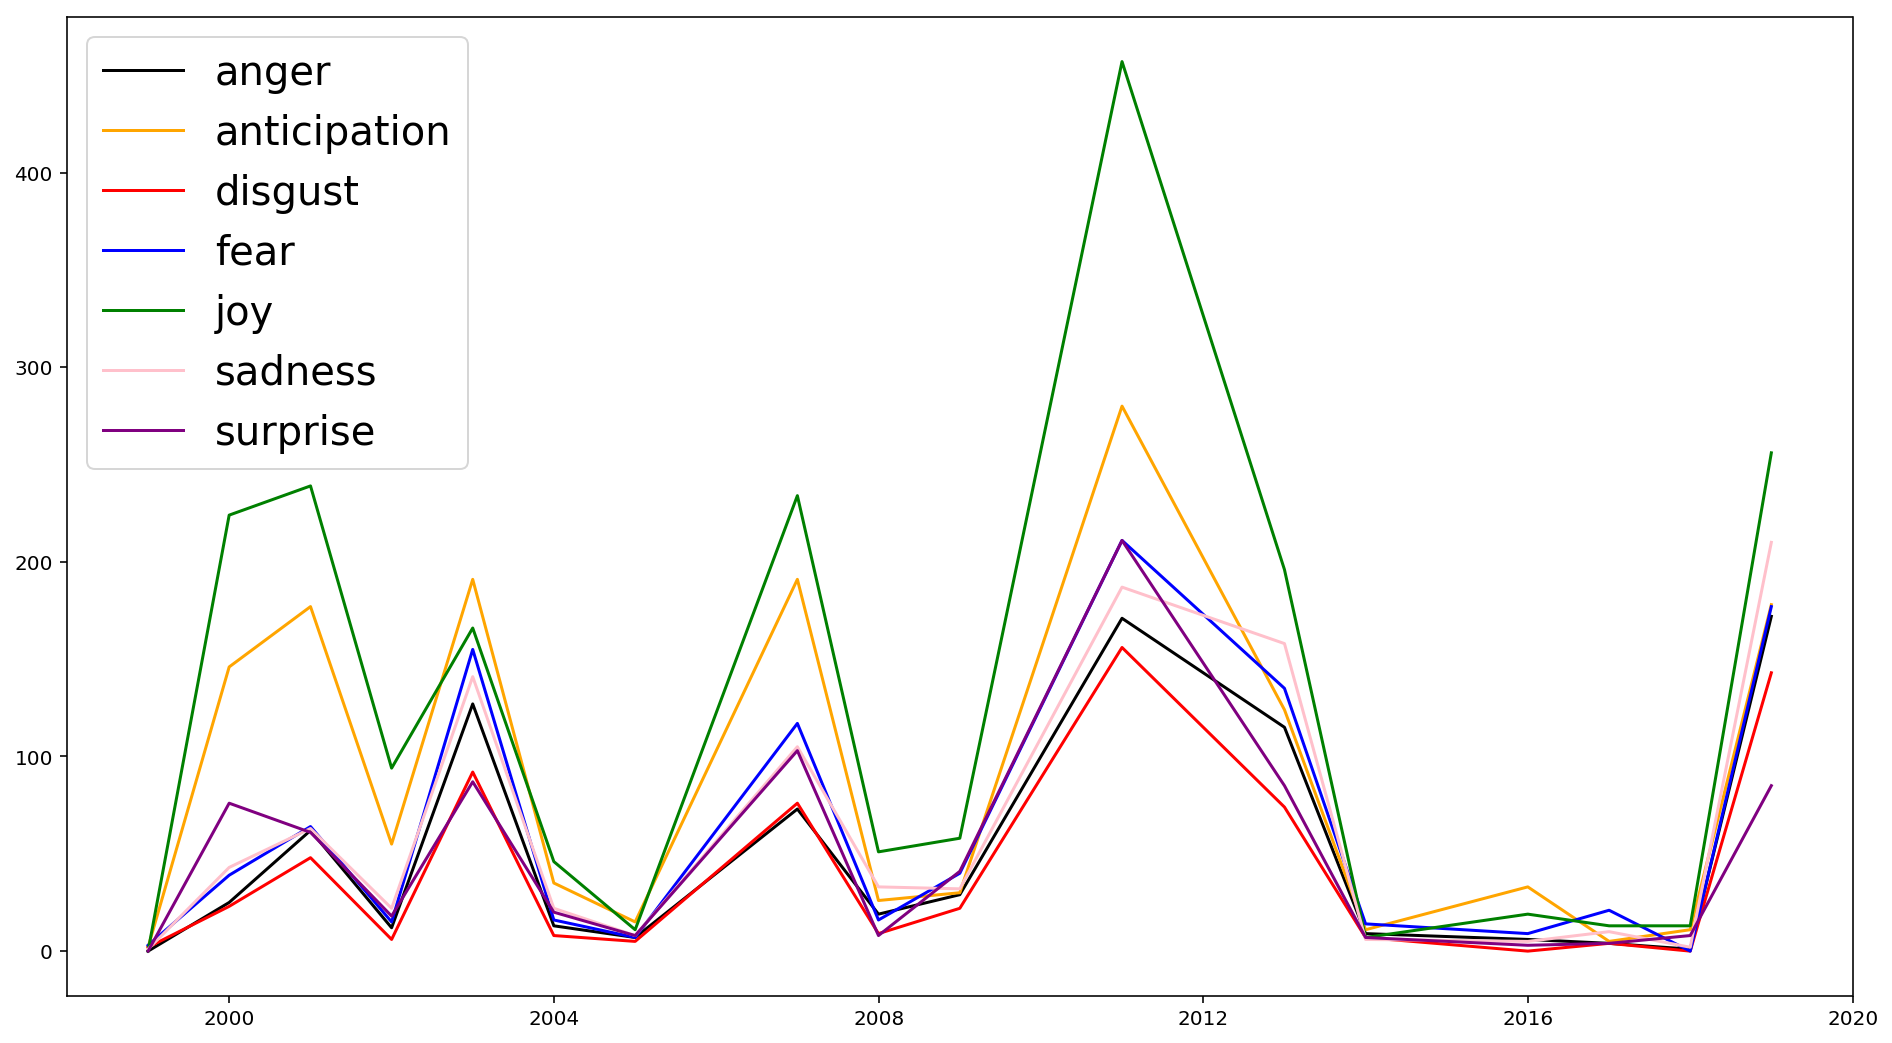

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='purple');
plt.legend(fontsize=20);

In [22]:
cols.remove('sum')
for col in cols:
    df_normalized[col] = df_normalized[col] / df_normalized['sum']

In [23]:
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-12-31,0.000000,0.074074,0.333333,0.074074,0.074074,0.111111,0.000000,0.037037,0.000000,0.296296,27
1999-12-31,0.020921,0.297908,0.051883,0.122176,0.019247,0.032636,0.187448,0.035983,0.063598,0.168201,1195
2000-12-31,0.049560,0.247002,0.072742,0.141487,0.038369,0.051159,0.191047,0.050360,0.048761,0.109512,1251
2001-12-31,0.026490,0.282561,0.075055,0.121413,0.013245,0.033113,0.207506,0.048565,0.039735,0.152318,453
2002-12-31,0.072738,0.182131,0.155212,0.109393,0.052692,0.088774,0.095074,0.080756,0.049828,0.113402,1746
2003-12-31,0.037143,0.268571,0.091429,0.100000,0.022857,0.045714,0.131429,0.062857,0.057143,0.182857,350
2004-12-31,0.057377,0.188525,0.188525,0.122951,0.040984,0.057377,0.090164,0.065574,0.065574,0.122951,122
2006-12-31,0.042740,0.219555,0.098946,0.111827,0.044496,0.068501,0.137002,0.061475,0.060304,0.155152,1708
2007-12-31,0.058642,0.231481,0.157407,0.080247,0.027778,0.049383,0.157407,0.101852,0.024691,0.111111,324


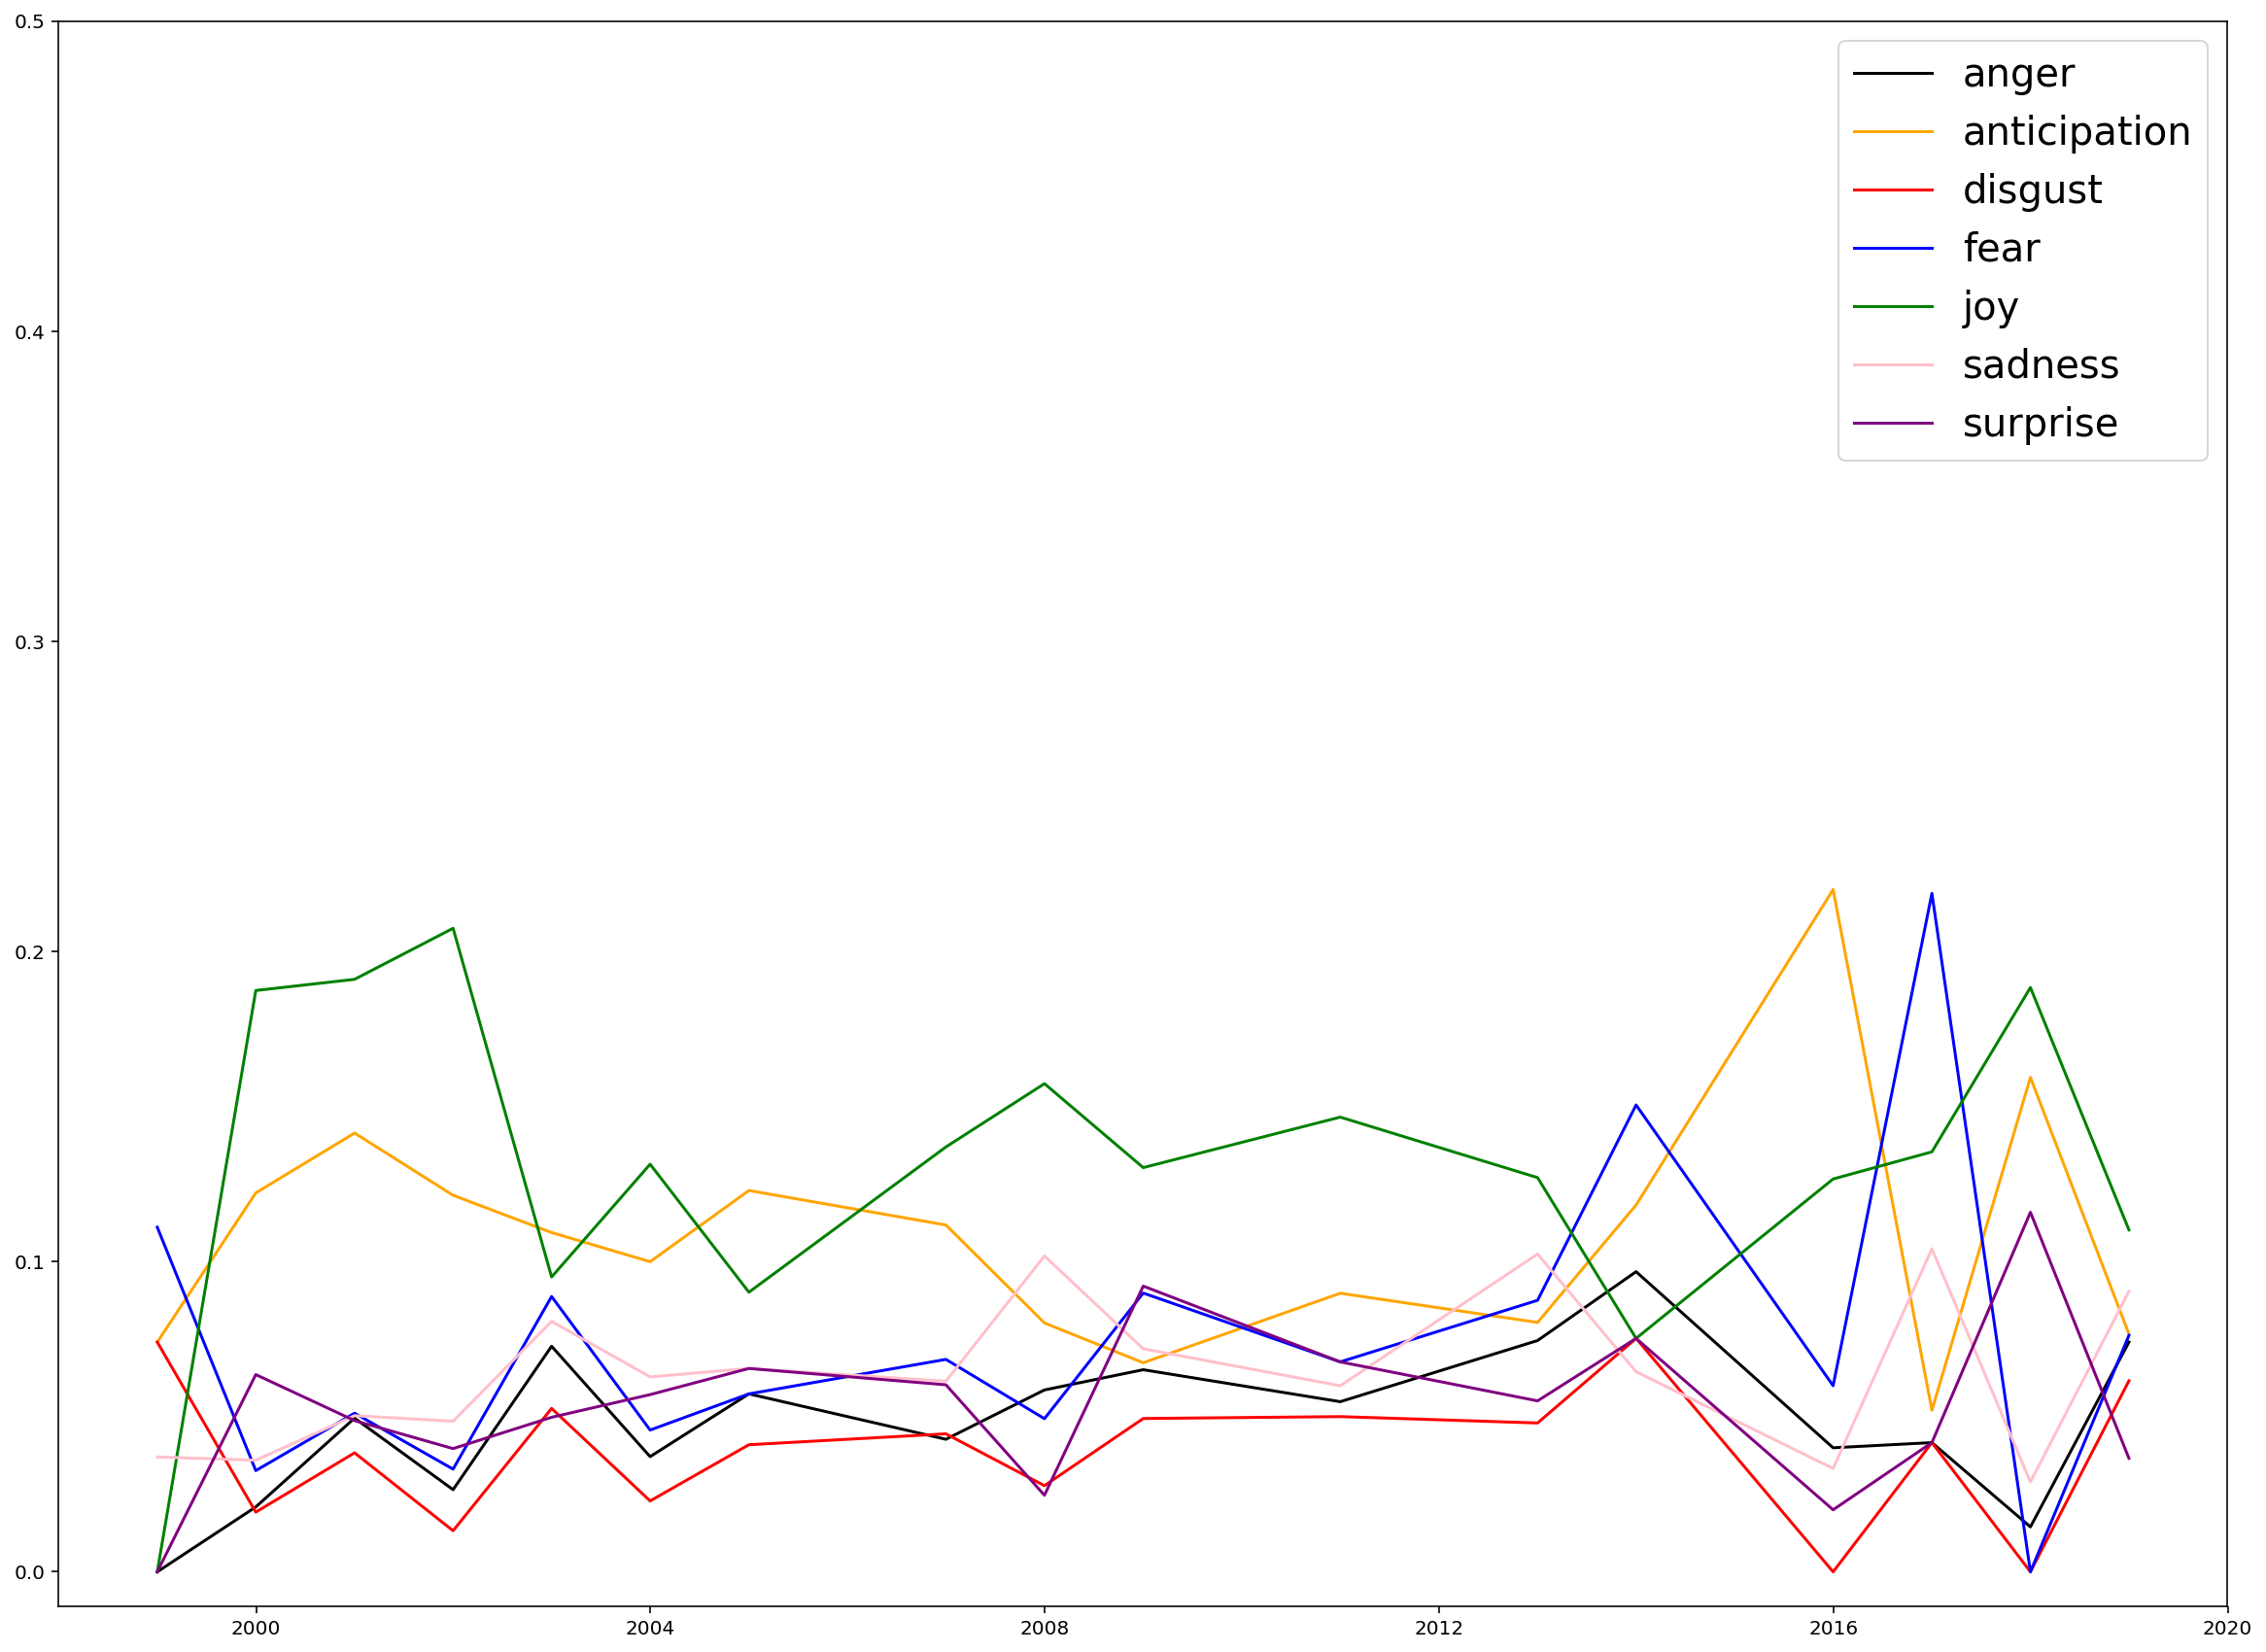

In [24]:
plt.figure(figsize=(20, 15))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='purple');
plt.ylim(top=0.5)
plt.legend(fontsize=20);

# 2. Clustering songs

https://www.sciencedirect.com/topics/computer-science/cosine-similarity

In [25]:
cluster_df = df[['title', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'surprise', 'trust']]
X = cluster_df.drop(['title'], axis=1)
y = cluster_df['title']

In [26]:
X.head()

,anger,anticipation,disgust,fear,joy,surprise,trust
0,19,17,5,20,16,10,18
1,1,11,4,0,19,3,22
2,1,9,1,4,11,5,11
3,0,3,4,2,29,3,8
4,1,11,0,0,13,8,13


In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)
pca = pca.fit_transform(X)

In [29]:
KMeans = KMeans(n_clusters = 4)
KMeans.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [30]:
pca = pd.DataFrame(pca, columns = ['Component1', 'Component2'])

In [31]:
pca['cluster'] = KMeans.labels_

In [32]:
KMeans.cluster_centers_

array([[  1.68647392, -11.48369948],
       [  7.90338613,   3.79284095],
       [ 39.41499696,   5.78296848],
       [-10.79221661,   2.82661112]])

In [33]:
pca.cluster.unique()

array([0, 1, 3, 2])

In [34]:
pca.head()

,Component1,Component2,cluster
0,14.852252,-16.056596,0
1,10.146178,5.328025,1
2,-0.368814,2.809132,1
3,8.462608,14.480658,1
4,2.883947,4.868473,1


In [35]:
pca.cluster.value_counts()

3    81
1    47
0    41
2    11
Name: cluster, dtype: int64

In [36]:
pca[pca.cluster == 1].index

Int64Index([  1,   2,   3,   4,   5,   8,   9,  10,  11,  16,  17,  19,  22,
             31,  44,  49,  51,  54,  55,  63,  68,  74,  75,  76,  80,  91,
             93,  94,  98, 113, 114, 134, 137, 138, 146, 150, 151, 153, 155,
            156, 157, 158, 162, 168, 171, 173, 175],
           dtype='int64')

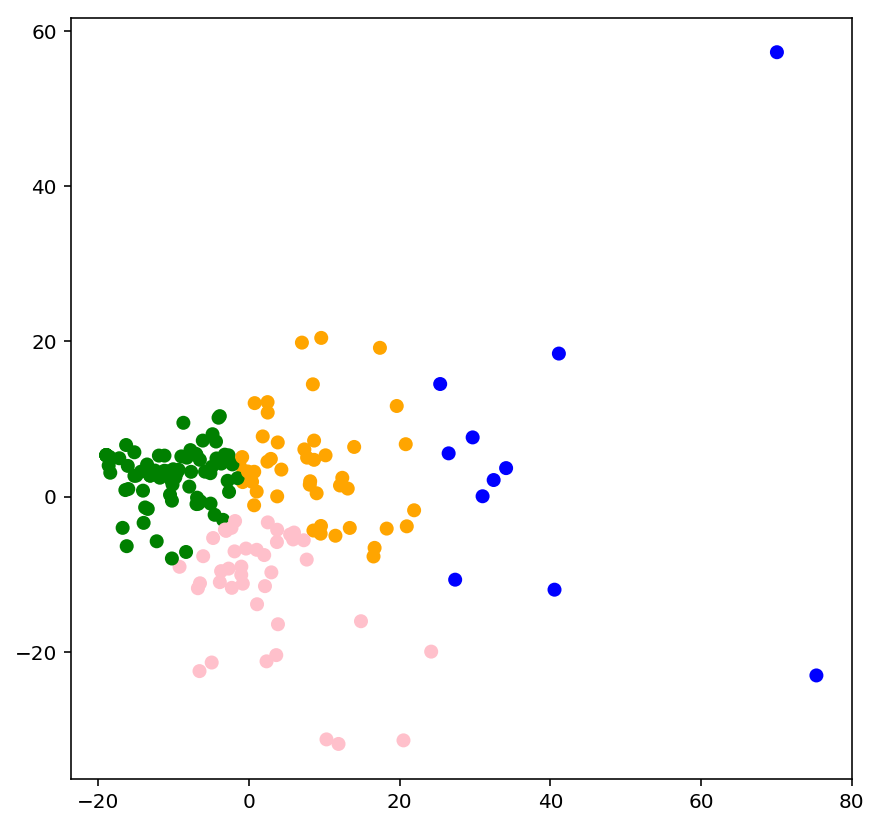

In [37]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green']
pca['color'] = pca['cluster'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['color']);

In [38]:
from sklearn.cluster import DBSCAN

In [39]:
dbscan = DBSCAN(eps=3, min_samples=15)

In [40]:
dbscan.fit(pca[['Component1', 'Component2']])

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=15, n_jobs=None, p=None)

In [41]:
pca['dbscan'] = dbscan.labels_

In [42]:
pca.dbscan.unique()

array([-1,  0,  1])

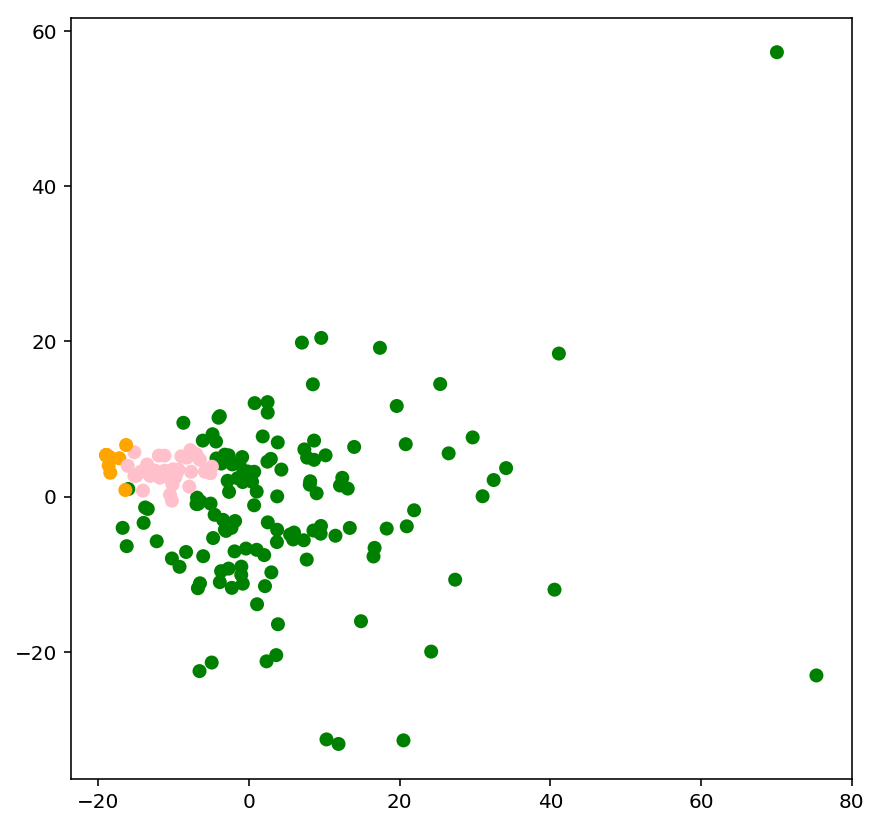

In [43]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green']
pca['dbscan_color'] = pca['dbscan'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['dbscan_color']);

In [44]:
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth=11)
ms.fit(pca[['Component1', 'Component2']])
pca['mean_shift'] = ms.labels_
pca.mean_shift.unique()

array([2, 1, 0, 6, 3, 5, 4])

# 3. Positivity Score

* greater than 0.05 --> positive
* between -0.05 and 0.05 --> neutral
* less than -0.05 --> negative

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [49]:
def lyrics_analyzer(lyrics):
    score = analyser.polarity_scores(lyrics)
    return score['compound']

In [50]:
polarity = []
for lyric in df['lyrics']:
    polarity.append(lyrics_analyzer(str(lyric)))

In [51]:
pd.DataFrame(polarity)

,0
0,-0.5435
1,0.9989
2,0.9947
3,0.9849
4,0.9935
5,0.9892
6,-0.8201
7,0.9388
8,0.9981
9,0.9874


# 4. Word Cloud

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

cv = CountVectorizer(min_df=0, stop_words="english", max_features=200)
counts = cv.fit_transform(df['lyrics'])                                               

In [51]:
words_freq = pd.DataFrame(counts.todense(), columns = cv.get_feature_names())
words_dict = {}
for word in words_freq.columns:
    words_dict[word] = words_freq[word].sum()

In [64]:
stopwords = set(STOPWORDS)
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(max_words=200,
               stopwords=stopwords,
               scale=5,
               height=300, 
               width=600, 
               max_font_size=80, 
               min_font_size=5,
               relative_scaling=0,
               colormap='gist_yarg',
               mask=mask,
               background_color='white').fit_words(words_dict)

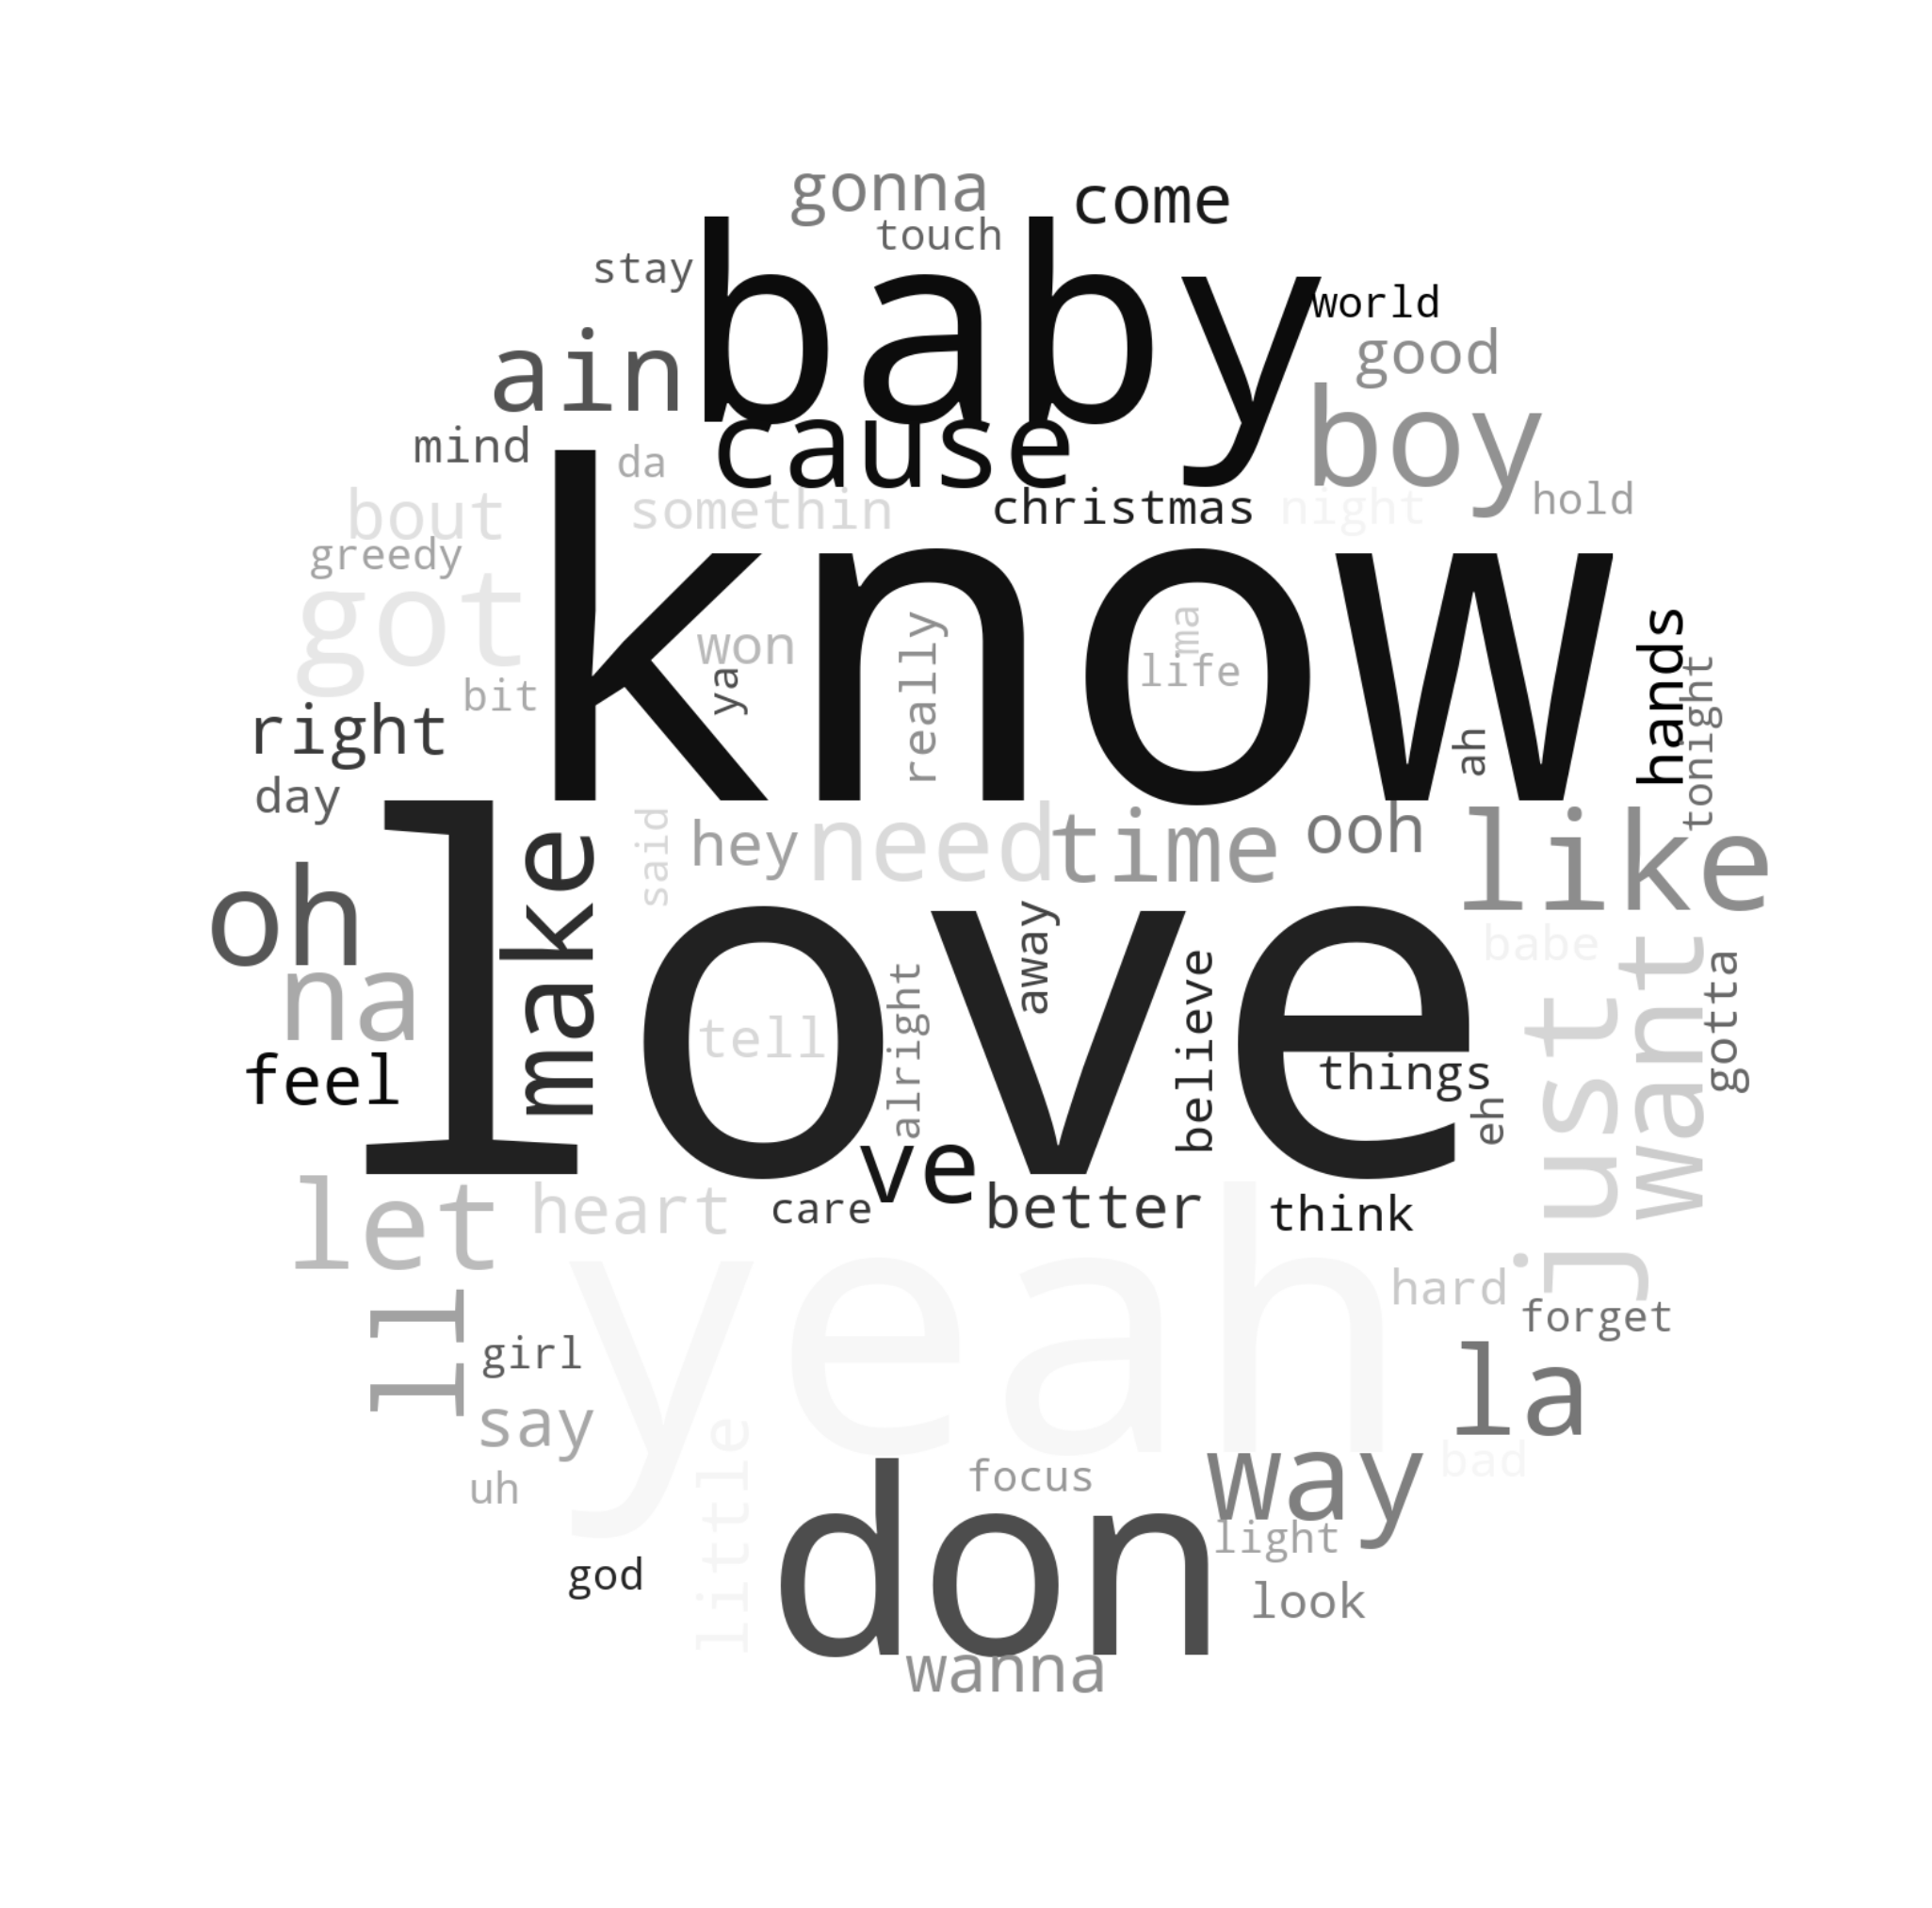

In [65]:
import random
plt.figure(figsize=[18,18])
plt.imshow(wc, interpolation="bilinear")
wc.to_file("ariana.png")
plt.axis("off")
plt.show()